### imports and configure servers

In [1]:
import json
import requests

from nimbro_vision_server.utils import load_image_b64, visualize_mmgroundingdino, visualize_sam2_prompts, visualize_sam2

# make sure to set a more secure token for your servers
TOKEN = "super_secret_access_token"
# in case you have different tokens per server use one header for each
headers = {
    "Authorization": f"Bearer {TOKEN}"
}

# in this example: all servers on localhost
# its also possible to launch the servers on different machines
mmgroundingdino_url = "http://localhost:9000"
sam2_realtime_url = "http://localhost:9001"
dam_url = "http://localhost:9002"

### /health and /status endpoints

In [2]:
for server_base in [mmgroundingdino_url, sam2_realtime_url, dam_url]:
    endpoint_url = f"{server_base}/health"
    response = requests.get(endpoint_url)
    if response.status_code == 200:
        data = response.json()
        print("Data:", data)
    else:
        print("Failed to retrieve health. Status code:", response.status_code)

for server_base in [mmgroundingdino_url, sam2_realtime_url, dam_url]:
    endpoint_url = f"{server_base}/status"
    response = requests.get(endpoint_url, headers=headers)
    if response.status_code == 200:
        data = response.json()
        print("Data:", data)
    else:
        print("Failed to retrieve status. Status code:", response.status_code)

Data: {'status': 'ok', 'cuda_available': True}
Data: {'status': 'ok', 'cuda_available': True}
Data: {'status': 'ok', 'cuda_available': True}
Data: {'model_family': 'mmgroundingdino', 'status': None}
Data: {'model_family': 'sam2_realtime', 'status': None}
Data: {'model_family': 'dam', 'status': None}


#### /load endpoint

* Alternatively use "export MMGROUNDINGDINO_PRELOAD_FLAVOR=large" before starting the server.

In [3]:
# load mmgrounddino weights of the desired type
mmgroundingdino_load_url = f"{mmgroundingdino_url}/load"
payload = {'flavor': 'large'}
response = requests.post(mmgroundingdino_load_url, json=payload, headers=headers)
output = response.json()
print(output)

{'loaded_model': 'Model', 'flavor': 'large'}


### /infer endpoint for object detection using mmgroundingdino

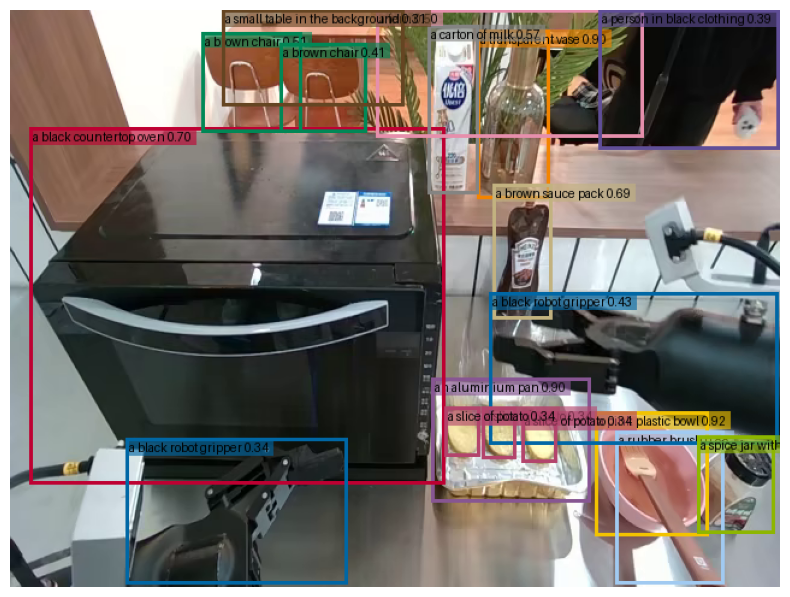

In [4]:
mmgroundingdino_infer_url = f"{mmgroundingdino_url}/infer"

img_b64 = load_image_b64('images/frame_0.png')

# for best results prompt for every visible object
prompts = ['a black countertop oven', 'a black robot gripper', 'a black robot gripper', 'a slice of potato', 'a slice of potato', 'a slice of potato', 'an aluminium pan', 'a pink plastic bowl', 'a rubber brush', 'a carton of milk', 'a transparent vase', 'a spice jar with a black lid', 'a brown sauce pack', 'a brown chair', 'a brown chair', 'a small table in the background', 'a fern', 'a person in black clothing']
inference_parameters= {'prompts': prompts, 'min_confidence': 0.05, 'overdetect_factor': 1., 'nms_iou': 0.5}

payload = {'images': [img_b64], 'inference_parameters': [inference_parameters]}

response = requests.post(mmgroundingdino_infer_url, json=payload, headers=headers)

if response.status_code == 200:
    mmgroundingdino_output = response.json()
else:
    print(f"Request failed with status code: {response.status_code}")
    print("Status:", response.status_code)
    print("Body:", response.text)

# to inspect this data you can also load the mmgroundingdino output from file
if False:
    with open("outputs/example_artifact_mmgroundingdino.json", "r", encoding="utf-8") as f:
        mmgroundingdino_output = json.load(f)

_ = visualize_mmgroundingdino(payload, mmgroundingdino_output)

### /unload mmgroundingdino and /load sam2_realtime

In [5]:
# if using small GPU, unload mmgroundingdino free up space
mmgroundingdino_unload_url = f"{mmgroundingdino_url}/unload"
response = requests.post(mmgroundingdino_unload_url, headers=headers)
output = response.json()
print(output)
# to check available model flavors, call the /model_flavors endpoint
sam2_realtime_flavors_url = f"{sam2_realtime_url}/model_flavors"
response = requests.get(sam2_realtime_flavors_url, headers=headers)
output = response.json()
print(output)
# load sam2_realtime weights of the desired type
sam2_realtime_load_url = f"{sam2_realtime_url}/load"
payload = {'flavor': 'large'}
response = requests.post(sam2_realtime_load_url, json=payload, headers=headers)
output = response.json()
print(output)

{'unloaded': True}
{'flavors': ['tiny', 'small', 'base', 'large']}
{'loaded_model': 'Model', 'flavor': 'large'}


### /update endpoint for sam2 tracker using the mmgroundingdino output

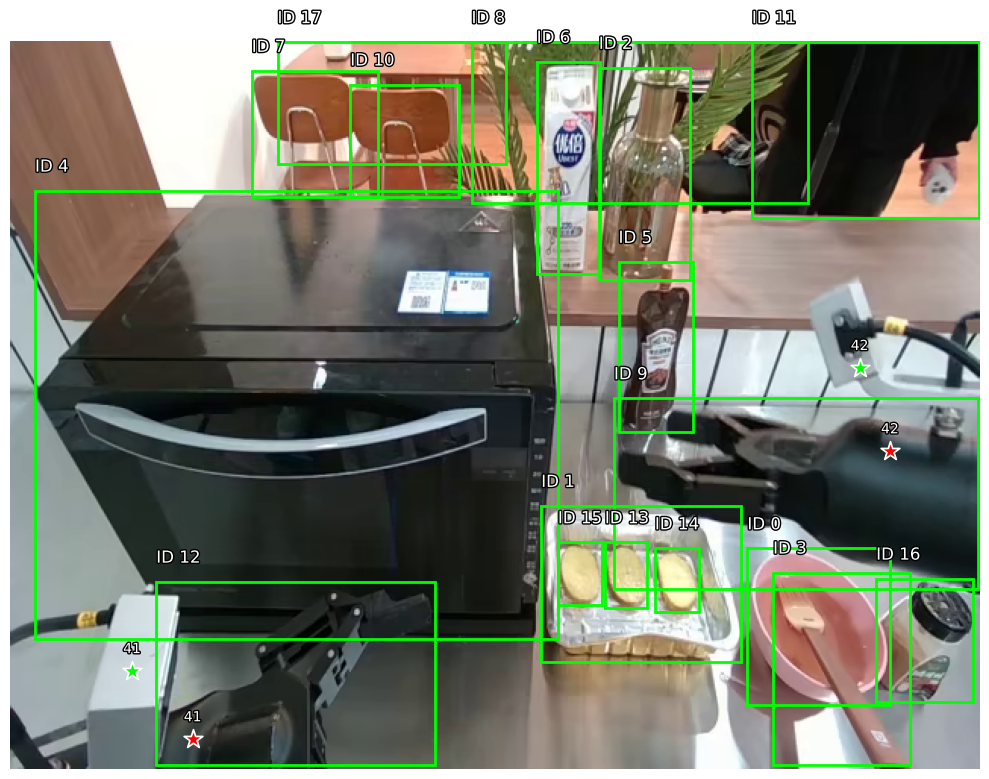

In [6]:
# take some box prompts from the previous mmgroundingdino detections 'object_id' is the track id that gets assigned to that detection
box_prompts = [{'object_id': idx, 'bbox': det['box_xyxy']} for idx, det in enumerate(mmgroundingdino_output['artifact']['detections'][0])]
# lets add some point prompts for the wrist cameras too (label 1/0: 'this point is on/off the object we want to track'
points_prompts = [{'object_id': 41, 'points': [[80,415], [120,460]], 'labels': [1, 0]}, {'object_id': 42, 'points': [[560,215], [580,270]], 'labels': [1, 0]}]
prompts = box_prompts + points_prompts
payload = {'image': img_b64, 'prompts': prompts}
# visualize these prompts
_ = visualize_sam2_prompts(payload)

# initialize the tracker (true updates are WIP)
sam2_realtime_update_url = f"{sam2_realtime_url}/update"

response = requests.post(sam2_realtime_update_url, json=payload, headers=headers)

if response.status_code == 200:
    sam2_realtime_update_output = response.json()
else:
    print(f"Request failed with status code: {response.status_code}")

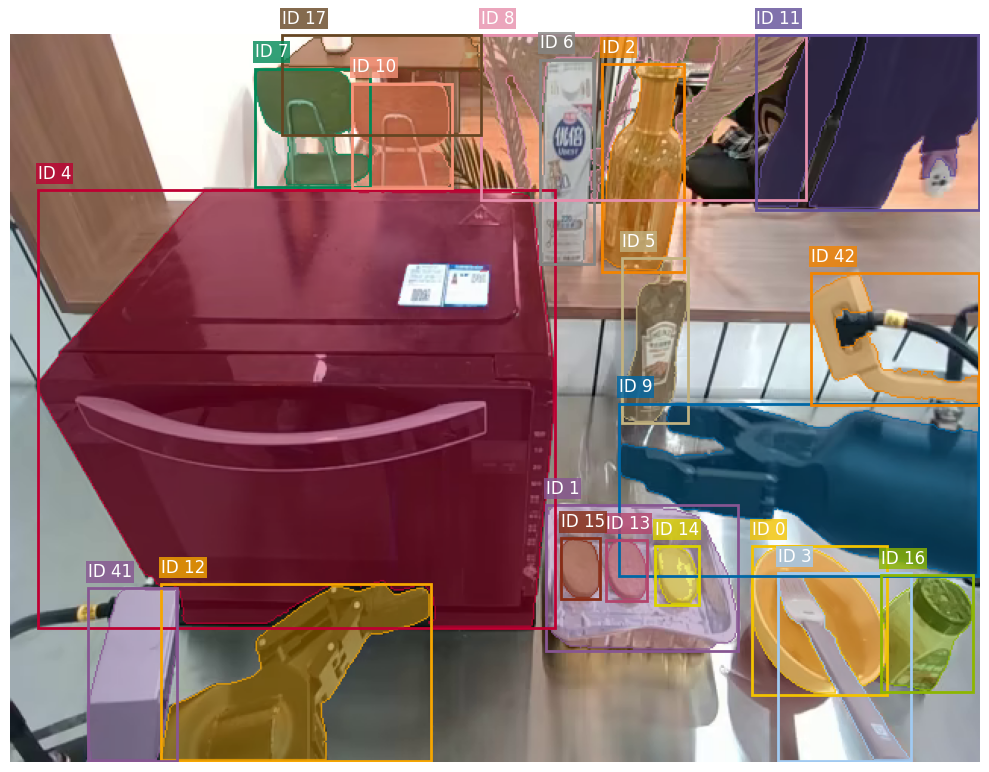

In [7]:
# to inspect this data you can also load the sam2_realtime /update output from file
if False:
    with open("outputs/example_artifact_sam2_realtime_update.json", "r", encoding="utf-8") as f:
        sam2_realtime_update_output = json.load(f)

_ = visualize_sam2(payload, sam2_realtime_update_output)

### /infer endpoint for tracking using sam2_realtime

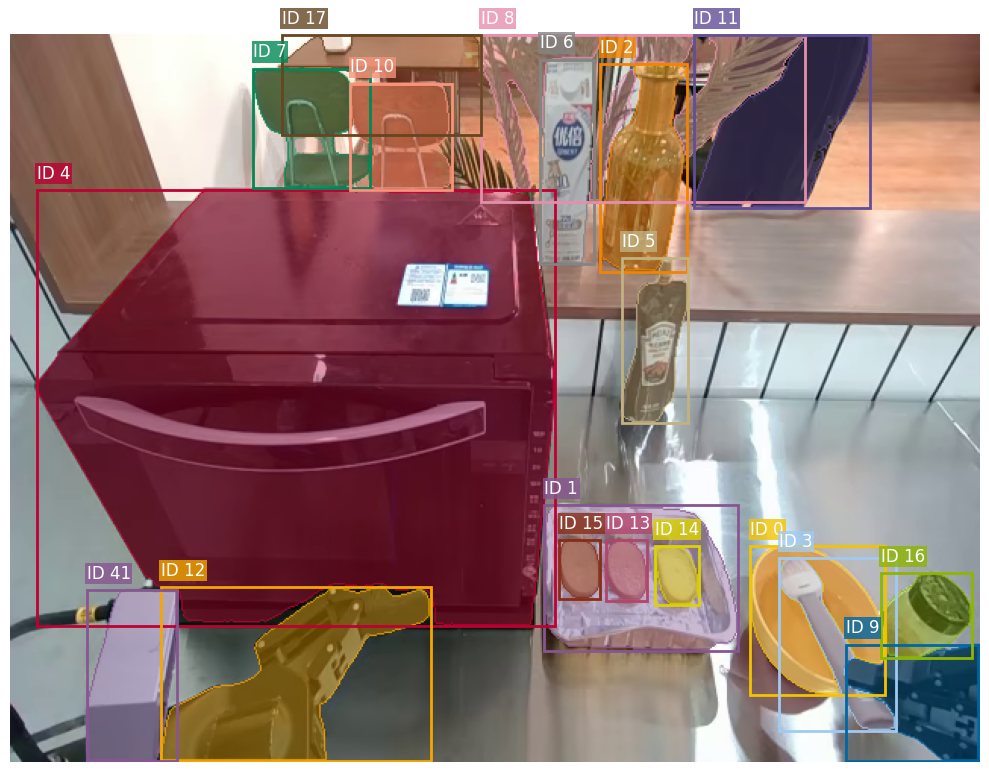

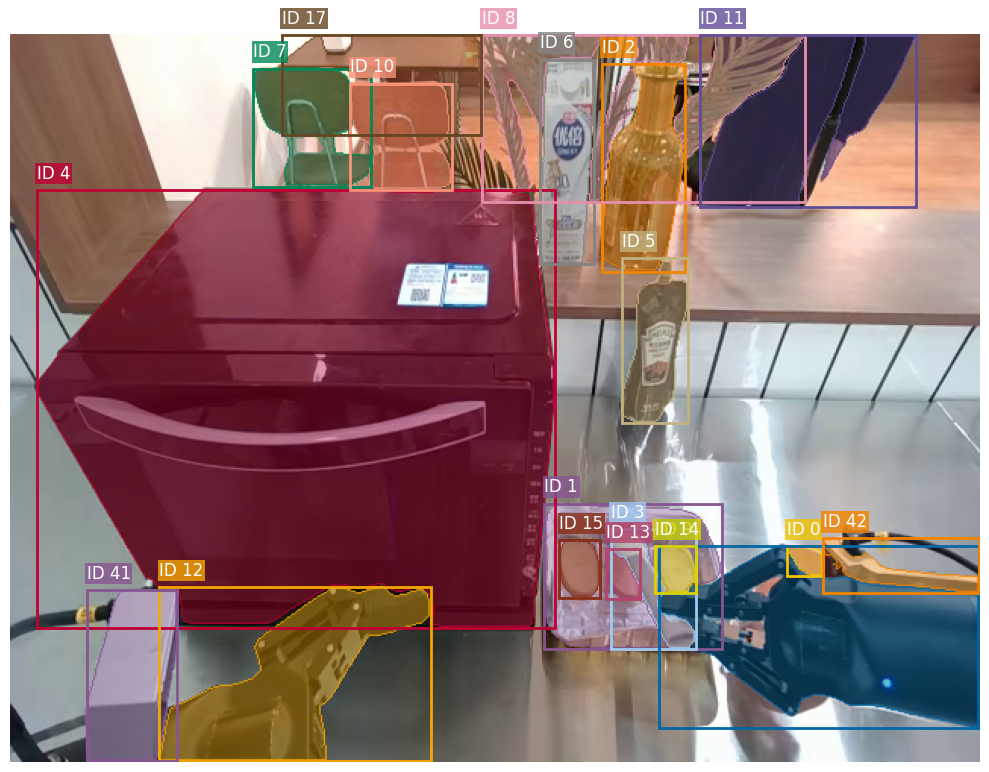

In [8]:
sam2_realtime_infer_url = f"{sam2_realtime_url}/infer"

future_frames_b64 = [load_image_b64(fp) for fp in ['images/frame_1.png', 'images/frame_2.png']]
# we can pass multiple next frames and the tracker will process them sequentially
payload = {'images': future_frames_b64}

response = requests.post(sam2_realtime_infer_url, json=payload, headers=headers)

if response.status_code == 200:
    sam2_realtime_output = response.json()
else:
    print(f"Request failed with status code: {response.status_code}")

# to inspect this data you can also load the sam2_realtime tracking output from file
if False:
    with open("outputs/example_artifact_sam2_realtime.json", "r", encoding="utf-8") as f:
        sam2_realtime_output = json.load(f)

_ = visualize_sam2(payload, sam2_realtime_output)

### /unload sam2_realtime and /load Describe Anything Model

In [9]:
# now unload sam2 to free up space
sam2_realtime_unload_url = f"{sam2_realtime_url}/unload"
response = requests.post(sam2_realtime_unload_url, headers=headers)
output = response.json()
print(output)
# load dam weights (note that this can take a while)
dam_load_url = f"{dam_url}/load"
payload = {'flavor': '3B'}
response = requests.post(dam_load_url, json=payload, headers=headers)
output = response.json()
print(output)

{'unloaded': True}
{'loaded_model': 'Model', 'flavor': '3B'}


### /infer endpoint for object description using the Describe Anything Model

In [10]:
dam_infer_url = f"{dam_url}/infer"

# for each image, prompts is a list of dicts with 'mask' and 'bbox' - bboxes help efficiently transfer the mask
prompts = [{'mask': tracklet['mask'], 'bbox': tracklet['box_xyxy']} for tracklet in sam2_realtime_update_output['artifact']['tracks'][0]]
# for each image, query is a string which instructs how to describe the prompts
query = 'Describe the masked region in one short sentence.'
# for each image, inference parameters determines the generation settings of DAM
inference_parameters = {'temperature': 0.2, 'top_p': 0.5, 'num_beams': 1, 'max_new_tokens': 512, 'max_batch_size': 32}

payload = {'images': [img_b64], 'inference_parameters': [inference_parameters], 'prompts': [prompts], 'queries': [query]}

response = requests.post(dam_infer_url, json=payload, headers=headers)

if response.status_code == 200:
    dam_output = response.json()
else:
    print(f"Request failed with status code: {response.status_code}")

# to inspect this data you can also load the dam output from file
if False:
    with open("outputs/example_artifact_dam.json", "r", encoding="utf-8") as f:
        dam_output = json.load(f)

for track_idx in range(len(sam2_realtime_update_output['artifact']['tracks'][0])):
    # description index 0 because we passed one frame and want the descriptions for that one
    description = dam_output['artifact']['descriptions'][0][track_idx]
    track_id = sam2_realtime_update_output['artifact']['tracks'][0][track_idx]['track_id']
    print(f"Description for ID {track_id}:\n'{description}'")

Description for ID 0:
'A smooth, round, light pink ceramic bowl with a glossy finish and a slightly curved rim.'
Description for ID 1:
'A rectangular aluminum foil tray with rounded corners, containing three oval-shaped, flat, yellowish objects arranged in a row.'
Description for ID 2:
'A tall, cylindrical glass vase with a narrow neck and a flared rim, containing green stems and leaves.'
Description for ID 3:
'A wooden spoon with a smooth, cylindrical handle that tapers slightly towards the end, featuring a rounded, shallow bowl with a visible grain pattern, suggesting a natural wood finish.'
Description for ID 4:
'A black microwave oven with a glossy finish, featuring a curved handle on the door, a digital control panel on the right side with multiple buttons, and a visible sticker on the top right corner.'
Description for ID 5:
'A dark brown, rectangular-shaped bottle with a white label featuring black and red text, a small image of a tomato, and a cork stopper.'
Description for ID 

In [11]:
# finally, unload DAM
dam_unload_url = f"{dam_url}/unload"
response = requests.post(dam_unload_url, headers=headers)
output = response.json()
print(output)

{'unloaded': True}
